# Matrix Factorization Study
---
Original [Google course](https://developers.google.com/machine-learning/recommendation/labs/movie-rec-programming-exercise)

Following guides from [colab notebook](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=WEhp-q31o4tS)




In [3]:
import os
import sys
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import altair as alt

sys.path.append("./m1-100k/")

In [4]:
# Adding some convenience functions to Pandas DataFrame
def mask(df, key, func):
    """Returns a filtered dataframe, by applying function to key"""
    new = df.copy()
    return new[func(new[key])]

def flatten_cols(df):
    new = df.copy()
    new.columns = [" ".join(col).strip() for col in new.columns.values]
    return new

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols


In [5]:
#import altair as alt

#alt.data_transformers.enable("default", max_rows=None)


# I. Getting started
---

## Downloading MovieLens

In [6]:
from urllib.request import urlretrieve
import zipfile

if not os.path.isdir("./ml-100k"):
    urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
    zip_ref = zipfile.ZipFile("movielens.zip", "r")
    zip_ref.extractall()
    
    print("Done. Dataset contains:")
    print(zip_ref.read("ml-100k/u.info"))
    zip_ref.close()

else:
    print("MovieLens already present in current directory.")
    
BASE_PATH = "./ml-100k/"

MovieLens already present in current directory.


## Loading the data

In [7]:
user_cols = ["user_id", "age", "sex", "occupation", "zip_code"]
users = pd.read_csv(
    BASE_PATH+"u.user", sep="|", names=user_cols, encoding="latin-1"
)

# All of the ideas start at 1, so need to shift this to 0
shift = lambda x: str(x-1)
users["user_id"] = users["user_id"].apply(shift)

users.head()

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [8]:
ratings_cols = ["user_id", "movie_id", "rating", "unix_timestamp"]
ratings = pd.read_csv(
    BASE_PATH+"u.data", sep="\t", names=ratings_cols, encoding="latin-1"
)

ratings["user_id"] = ratings["user_id"].apply(shift)
ratings["movie_id"] = ratings["movie_id"].apply(shift)

# Convert rating to float
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596


In [9]:
genres = [line.split("|")[0] for line in open(BASE_PATH+"u.genre", "r")]
genres.pop(-1)
print(genres)

['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [10]:
# Movies are stored in file with a multi-hot encoding of genre, so need to add the genre columns
movie_cols = ["movie_id", "title", "release_date", "video_release_date", "imdb_url"] + genres

movies = pd.read_csv(
    BASE_PATH+"u.item", sep="|", names=movie_cols, encoding="latin-1"
)

movies["movie_id"] = movies["movie_id"].apply(shift)

# Reduce date to just year
movies["release_date"] = movies["release_date"].apply(lambda x: str(x).split("-")[-1])

movies.head(5)

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Toy Story (1995),1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,Four Rooms (1995),1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,Get Shorty (1995),1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Quick preprocessing

In [11]:
# Constants for total number of movies and users
TOTAL_USER = users.shape[0]
TOTAL_MOVIE = movies.shape[0]

In [12]:
genre_occur = movies[genres].sum().to_dict()
print(genre_occur)

{'unknown': 2, 'Action': 251, 'Adventure': 135, 'Animation': 42, "Children's": 122, 'Comedy': 505, 'Crime': 109, 'Documentary': 50, 'Drama': 725, 'Fantasy': 22, 'Film-Noir': 24, 'Horror': 92, 'Musical': 56, 'Mystery': 61, 'Romance': 247, 'Sci-Fi': 101, 'Thriller': 251, 'War': 71, 'Western': 27}


In [13]:
# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
    new_movies = movies.copy()
    
    def get_random_genre(g_vector):
        active = [genre for genre, g in zip(genres, g_vector) if g==1]
        if len(active) == 0:
            return "Other"
        return np.random.choice(active)
    
    def get_all_genres(g_vector):
        active = [genre for genre, g in zip(genres, g_vector) if g==1]
        if len(active) == 0:
            return "Other"
        return "-".join(active)
    
    new_movies["genre"] = [
        get_random_genre(g_vector) for g_vector in zip(*[new_movies[genre] for genre in genres])
    ]
    new_movies["all_genres"] = [
        get_all_genres(g_vector) for g_vector in zip(*[new_movies[genre] for genre in genres])
    ]
    
    return new_movies

# All this is doing is turning the multi hot encoding for genre into categorical columns
movies = mark_genres(movies, genres).drop(genres, axis=1)

In [14]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre,all_genres
0,0,Toy Story (1995),1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Comedy,Animation-Children's-Comedy
1,1,GoldenEye (1995),1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,Adventure,Action-Adventure-Thriller
2,2,Four Rooms (1995),1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller,Thriller
3,3,Get Shorty (1995),1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,Drama,Action-Comedy-Drama
4,4,Copycat (1995),1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime,Crime-Drama-Thriller


In [16]:
movie_lens = ratings.merge(movies, on="movie_id").merge(users, on="user_id")
movie_lens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),Comedy,Comedy,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,Action,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,Romance,Comedy-Romance,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",Comedy,Comedy,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,Comedy,Comedy-Drama,49,M,writer,55105


In [ ]:
def split_dataframe(df, holdout_fraction=0.1):
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)] # ~ is some random numpy specific logical not operator
    return train, test

train, test = split_dataframe(movie_lens, 0.1)

# II. Exploring MovieLens
---

## 1. Users

Following only works for the numeric features (i.e. the age)

In [17]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
age,943.0,34.051962,12.19274,7.0,25.0,31.0,43.0,73.0


Can include "object" types to account for non-numeric types.

In [18]:
users.describe(include=[object])

,user_id,sex,occupation,zip_code
count,943,943,943,943
unique,943,2,21,795
top,0,M,student,55414
freq,1,670,196,9


### Altair visualization code

#### User

In [ ]:
# @title Altair visualization code (run this cell)
# The following functions are used to generate interactive Altair charts.
# We will display histograms of the data, sliced by a given attribute.

# Create filters to be used to slice the data.
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(0.7)),
  ).resolve_scale(y='independent')


In [ ]:
user_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on="user_id")
)

alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data=user_ratings)

#### Movies

In [ ]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [ ]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .sort_values('rating count', ascending=False)
 .head(10))

In [ ]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 20)
 .sort_values('rating mean', ascending=False)
 .head(10))

In [ ]:
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

# III. Preliminaries

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.



## Sparse Representation of the Rating Matrix

The rating matrix could be very large and, in general, most of the entries are unobserved, since a given user will only rate a small subset of movies. For effcient representation, we will use a [tf.SparseTensor](https://www.tensorflow.org/api_docs/python/tf/SparseTensor). A `SparseTensor` uses three tensors to represent the matrix: `tf.SparseTensor(indices, values, dense_shape)` represents a tensor, where a value $A_{ij} = a$ is encoded by setting `indices[k] = [i, j]` and `values[k] = a`. The last tensor `dense_shape` is used to specify the shape of the full underlying matrix.

In [19]:
import torch
from torch import nn

In [20]:
class SparseMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self._criterion = nn.MSELoss()
        
    def forward(self, U, V, sparse_ratings):
        # Predicted ratings (1-5)
        
        embedding_dim = U.shape[1]
        predictions = torch.sum(
            torch.gather(U, 0, sparse_ratings.indices()[0].expand(embedding_dim, -1).T) *
            torch.gather(V, 0, sparse_ratings.indices()[1].expand(embedding_dim, -1).T),
            axis=1
            )
            
        loss = self._criterion(sparse_ratings.values(), predictions)
        return loss

In [21]:
class Regularization(nn.Module):
    def __init__(self, reg_strength=0.1):
        # Maybe support different norms here in the future?
        super().__init__()
        self._reg_strength = reg_strength
    
    def forward(self, U, V, sparse_ratings=None):
        avg_norm_U = torch.mean(torch.linalg.norm(U, dim=1, ord=2))
        avg_norm_V = torch.mean(torch.linalg.norm(V, dim=1, ord=2))
        
        return self._reg_strength * (avg_norm_U + avg_norm_V)

In [22]:
import copy 

class NMFModel(nn.Module):
    def __init__(self, U, V):
        super().__init__()
        self._history = defaultdict(list)
        self.U = nn.Parameter(U)
        self.V = nn.Parameter(V)
        self._embedding_dim = U.shape[1]
        
    @property
    def ratings(self):
        return (self.U.detach() @ self. V.T.detach()).clone()
    
    def fit(self, train, test, n_iter, optimizer, loss, restore_best=False):
        if restore_best:
            best_param = copy.deepcopy(self.state_dict())
            best_loss = float("inf")

        for i in range(n_iter):
            optimizer.zero_grad()
            
            train_loss = 0
            test_loss = 0
            
            with torch.no_grad():
                self.U.abs_()
                self.V.abs_()
            
            for func in loss: 
                train_loss += func(self.U,
                                   self.V,
                                   train)
                
                with torch.inference_mode():
                    test_loss += func(self.U,
                                      self.V,
                                      test)
           
            self._history["train"].append(train_loss.item())
            self._history["test"].append(test_loss.item())

            if restore_best and (test_loss < best_loss):
                best_param = copy.deepcopy(self.state_dict())
                best_loss = test_loss
            
            train_loss.backward()
            optimizer.step()
        
            print("Iteration: %i\t Train loss: %.3f\t Val loss: %.3f" % (i, train_loss, test_loss), end="\r")
        
        if restore_best:
            print("Restoring best weights with Val loss: %.3f" % (best_loss), end="\r")
            self.load_state_dict(best_param)
        
        with torch.no_grad():
            self.U.abs_()
            self.V.abs_()
        
        return self._history
    
    def predict(self, sparse_ratings, measure="dot"):
        # This is exactly the same as just taking the dot product of each query with each item
        with torch.inference_mode():
            gathered_user = torch.gather(
                self.U, 0, sparse_ratings.indices()[0].expand(self._embedding_dim, -1).T
                )
            gathered_item = torch.gather(
                self.V, 0, sparse_ratings.indices()[1].expand(self._embedding_dim, -1).T
                )
            
            if measure == "cosine":
                norm = torch.linalg.norm(gathered_user, dim=-1) * \
                    torch.linalg.norm(gathered_item, dim=-1)
            else:
                norm = 1
            
            predictions = torch.sum(gathered_user * gathered_item, dim=1) / norm
            
            # Faster to copy everything to cpu and then call item()
            combined = zip(sparse_ratings.indices()[0].cpu(),
                           sparse_ratings.indices()[1].cpu(),
                           predictions.cpu(), 
                           sparse_ratings.values().cpu()
                           )
            
            # Formatting the ratings into (user_id, item_id, estimated rating, true rating)
            user_pred = [(user.item(), item.item(), est.item(), true.item()) for user, item, est, true in combined]
        return user_pred
    
    def get_top_k(self, q, mode, k=10, measure="cosine", exclude_items=None):
        with torch.inference_mode():
            iid =  torch.arange(self.V.shape[0])

            if mode == "user":
                query = self.U[q]
            elif mode == "item":
                query = self.V[q]
            else:
                raise ValueError("Unexpected argument for 'mode.' Possible alternatives are: ('user', 'item')")
            
            if measure == "cosine":
                norm = torch.linalg.norm(query, dim=-1) * torch.linalg.norm(self.V, dim=-1)
            else:
                norm = 1
            
            sim = (query @ self.V.T) / norm

            if exclude_items:
                mask = torch.ones(self.V.shape[0], dtype=bool)
                mask[exclude_items] = False

                sim = sim[mask]
                iid = iid[mask]

            ratings = [(item.item(), score.item()) for item, score in zip(iid, sim)]

        return sorted(ratings, key=lambda x: x[1], reverse=True)[:k]
            

In [23]:
def build_model(dim, embedding_dim=3, init_stddev=1.,
                device="cuda", random_state=0):
    
    torch.random.manual_seed(random_state)
    # Embeddings for users
    U = torch.distributions.Normal(loc=0, scale=init_stddev).sample(
        (dim[0], embedding_dim)
        ).to(device=device)
    U.requires_grad = True
    
    # Embeddings for movies
    V = torch.distributions.Normal(loc=0, scale=init_stddev).sample(
        (dim[1], embedding_dim)
        ).to(device=device)
    V.requires_grad=True
    
    return NMFModel(U, V)

In [24]:
def build_rating_sparse_tensor(ratings_df, device="cuda"):
    index = ratings_df[["user_id", "movie_id"]].values.astype("int32")
    ratings = ratings_df["rating"].values
    
    return torch.sparse_coo_tensor(
        indices=index.T, values=ratings, size=(TOTAL_USER, TOTAL_MOVIE), device=device
        ).coalesce().type(torch.float32)

In [25]:
# Train set
train = pd.read_csv(
    BASE_PATH+"u1.base", delimiter="\t", names=["user_id", "movie_id", "rating", "timestamp"]
    )
train[["user_id", "movie_id"]] = train[["user_id", "movie_id"]] - 1

# Test set
test = pd.read_csv(
    BASE_PATH+"u1.test", delimiter="\t", names=["user_id", "movie_id", "rating", "timestamp"]
    )
test[["user_id", "movie_id"]] = test[["user_id", "movie_id"]] - 1

val = test.sample(frac=.50, axis=0, random_state=192)

# Taking set difference so validation and test sets don't overlap
test = pd.concat((test, val, val)).drop_duplicates(keep=False)

# Full set
full = pd.concat([train, test])
full = full.sort_values(["user_id", "movie_id"])

sparse_train = build_rating_sparse_tensor(train, device="cuda")
sparse_val = build_rating_sparse_tensor(val, device="cuda")
sparse_test = build_rating_sparse_tensor(test, device="cuda")
sparse_full = build_rating_sparse_tensor(full, device="cuda")

In [26]:
model = build_model(
    sparse_train.shape,
    embedding_dim=30,
    device="cuda",
    random_state=192,
    init_stddev=0.5
)

opt = torch.optim.SGD(
    model.parameters(),
    lr=5
)

loss = [SparseMSELoss(), Regularization(reg_strength=0.1)]

hist = model.fit(
    sparse_train,
    sparse_val,
    3_000,
    opt,
    loss,
    restore_best=True
)

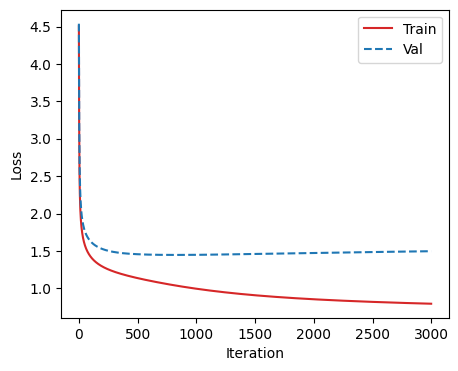

In [27]:
import matplotlib.pyplot as plt

x = np.arange(len(hist["train"]))

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, hist["train"], color="tab:red", label="Train")
ax.plot(x, hist["test"], color="tab:blue", linestyle="--", label="Val")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
plt.legend()
plt.show()

# IV. Making Predictions & Evaluating

In [35]:
def precision_recall_at_k(predictions, k, threshold):
    user_est_true = defaultdict(list)
    precision = dict()
    recall = dict()

    for uid, _, est, true in predictions:
        # Need to do this step because some users may have different numbers of rated items
        user_est_true[uid].append((est, true))
    
    for uid, user_ratings in user_est_true.items():
        sorted_ratings = sorted(user_ratings, key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in sorted_ratings)

        n_rec_k = sum((est >= threshold) for (est, _) in sorted_ratings[:k])

        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in sorted_ratings[:k]
        )

        precision_at_k = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recall_at_k = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        precision[uid] = precision_at_k
        recall[uid] = recall_at_k

    return precision, recall

predictions = model.predict(sparse_test)
p, r = precision_recall_at_k(predictions, 20, 3)

In [29]:
def map_mar_at_k(predictions, k, threshold):
    user_est_true = defaultdict(list)
    ap = defaultdict(list)
    ar = defaultdict(list)

    for uid, _, est, true in predictions:
        # Need to do this step because some users may have different numbers of rated items
        user_est_true[uid].append((est, true))
    
    for uid, user_ratings in user_est_true.items():
        sorted_ratings = sorted(user_ratings, key=lambda x: x[0], reverse=True)

        for i in range(k):
            n_rel = sum((true_r >= threshold) for (_, true_r) in sorted_ratings[:i])

            n_rec_k = sum((est >= threshold) for (est, _) in sorted_ratings[:i])

            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in sorted_ratings[:i]
            )

            precision_at_k = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recall_at_k = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

            ap[uid].append(precision_at_k)
            ar[uid].append(recall_at_k)
        
        ap[uid] = np.mean(ap[uid])
        ar[uid] = np.mean(ar[uid])
    
    metrics = {"map":None, "mar":None}
    metrics["map"] = np.mean(list(ap.values()))
    metrics["mar"] = np.mean(list(ar.values()))
    
    return metrics


map_mar_at_k(predictions, 5, 3)

{'map': 0.7300946142649201, 'mar': 0.7580058224163029}

# Comparing Embeddings with GPT

In [30]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, 
                  perplexity=25,
                  init="pca",
                  random_state=192)\
    .fit_transform(model.V.cpu().detach().numpy())

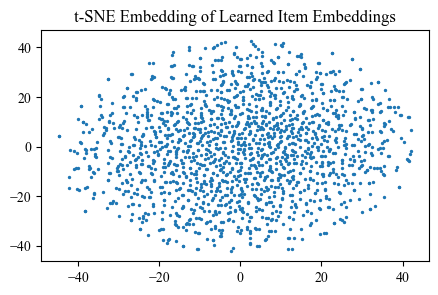

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mp

mp.rcParams["font.family"]= "Times New Roman"
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], s=2, color="tab:blue")
plt.title("t-SNE Embedding of Learned Item Embeddings")
plt.show()

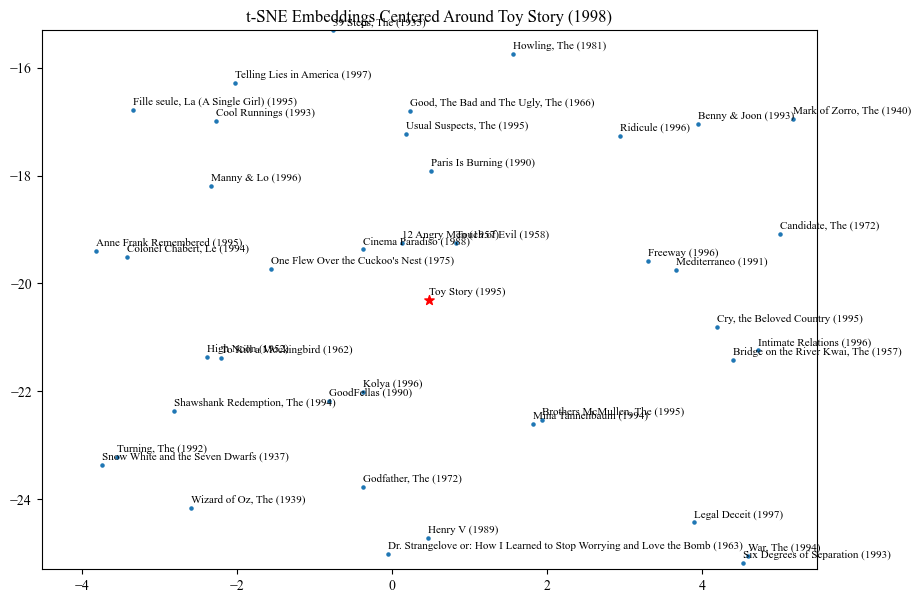

In [33]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], s=5)
ax.scatter(X_embedded[0, 0], X_embedded[0, 1], s=50, color="red", marker="*")
ax.set_xlim(X_embedded[0, 0]-5, X_embedded[0, 0]+5)
ax.set_ylim(X_embedded[0, 1]-5, X_embedded[0, 1]+5)

for i, title in enumerate(movies["title"]):
    ax.annotate(title,
                xy=(X_embedded[i, 0], X_embedded[i, 1]),
                xytext=(X_embedded[i, 0], X_embedded[i, 1]+0.1),
                fontsize=8)

ax.set_title("t-SNE Embeddings Centered Around Toy Story (1998)")
plt.show()